In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 98 #novel number
t = 'Tale_2_Cities'#novel name
s = 1 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,"The Period It was the best of times, it was ..."
1,There were a king with a large jaw and a queen...
2,In both countries it was clearer than crystal ...
3,It was the year of Our Lord one thousand seven...
4,Spiritual revelations were conceded to England...


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,"The Period It was the best of times, it was ...","[3, 6, 2, 3, 3, 4, 2, 5, 2, 3, 3, 5, 2, 5, 2, ...",484
1,There were a king with a large jaw and a queen...,"[5, 4, 1, 4, 4, 1, 5, 3, 3, 1, 5, 4, 1, 5, 4, ...",138
2,In both countries it was clearer than crystal ...,"[2, 4, 9, 2, 3, 7, 4, 7, 2, 3, 5, 2, 3, 5, 9, ...",121
3,It was the year of Our Lord one thousand seven...,"[2, 3, 3, 4, 2, 3, 4, 3, 8, 5, 7, 3, 12]",59
4,Spiritual revelations were conceded to England...,"[9, 11, 4, 8, 2, 7, 2, 4, 8, 6, 2, 2, 4]",69


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,"The Period It was the best of times, it was ...","[3, 6, 2, 3, 3, 4, 2, 5, 2, 3, 3, 5, 2, 5, 2, ...",484,"[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,There were a king with a large jaw and a queen...,"[5, 4, 1, 4, 4, 1, 5, 3, 3, 1, 5, 4, 1, 5, 4, ...",138,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,In both countries it was clearer than crystal ...,"[2, 4, 9, 2, 3, 7, 4, 7, 2, 3, 5, 2, 3, 5, 9, ...",121,"[1, 1, 2, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, ..."
3,It was the year of Our Lord one thousand seven...,"[2, 3, 3, 4, 2, 3, 4, 3, 8, 5, 7, 3, 12]",59,"[1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 4]"
4,Spiritual revelations were conceded to England...,"[9, 11, 4, 8, 2, 7, 2, 4, 8, 6, 2, 2, 4]",69,"[3, 4, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1]"


In [17]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [18]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [19]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [20]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [21]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [22]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [23]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [24]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,"The Period It was the best of times, it was ...","[3, 6, 2, 3, 3, 4, 2, 5, 2, 3, 3, 5, 2, 5, 2, ...",484,[1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1...,170,0.022917
1,There were a king with a large jaw and a queen...,"[5, 4, 1, 4, 4, 1, 5, 3, 3, 1, 5, 4, 1, 5, 4, ...",138,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1...,41,0.228571
2,In both countries it was clearer than crystal ...,"[2, 4, 9, 2, 3, 7, 4, 7, 2, 3, 5, 2, 3, 5, 9, ...",121,[1 1 2 1 1 3 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 3...,35,0.050000
3,It was the year of Our Lord one thousand seven...,"[2, 3, 3, 4, 2, 3, 4, 3, 8, 5, 7, 3, 12]",59,[1 1 1 2 1 1 1 1 2 2 1 1 4],19,0.000000
4,Spiritual revelations were conceded to England...,"[9, 11, 4, 8, 2, 7, 2, 4, 8, 6, 2, 2, 4]",69,[3 4 1 2 1 2 1 1 2 2 1 1 1],22,0.000000


Create cluster dataframe - remove columns that can't be used

In [25]:
df_cluster = df_novel.drop('wrd_length', 1)

In [26]:
df_cluster = df_cluster.drop('syl_count', 1)

In [27]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,"The Period It was the best of times, it was ...",484,170,0.022917
1,There were a king with a large jaw and a queen...,138,41,0.228571
2,In both countries it was clearer than crystal ...,121,35,0.050000
3,It was the year of Our Lord one thousand seven...,59,19,0.000000
4,Spiritual revelations were conceded to England...,69,22,0.000000


Create 20 clusters on scaled data

In [28]:
X = df_cluster.drop(0, axis=1)

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [31]:
df_cluster['cluster'] = km.labels_

In [32]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,48.021084,15.228916,-0.207971
1,190.719298,60.850877,0.307834
2,43.629738,13.772595,0.247149
3,207.034091,65.367424,-0.007941
4,35.011935,11.182438,0.002395
5,393.216667,125.166667,0.120360
6,34.153374,10.871166,0.784762
7,108.806630,34.671271,0.262084
8,74.840909,24.363636,-0.939886


In [33]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [34]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

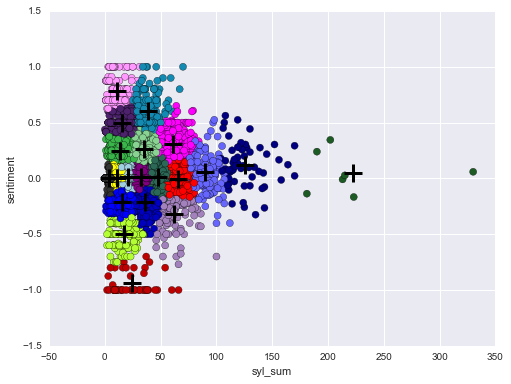

In [35]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [36]:
df_cluster_3 = df_cluster

In [37]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,"The Period It was the best of times, it was ...",484,170,0.022917,5
1,There were a king with a large jaw and a queen...,138,41,0.228571,7
2,In both countries it was clearer than crystal ...,121,35,0.050000,11
3,It was the year of Our Lord one thousand seven...,59,19,0.000000,19
4,Spiritual revelations were conceded to England...,69,22,0.000000,19


In [38]:
X = df_cluster_3.drop(0, axis=1)

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [41]:
df_cluster_3['cluster'] = km.labels_

In [42]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,185.656138,58.889750,0.078955
1,31.968719,10.167720,0.063512
2,57.042656,18.113214,0.017215


Create 3 Clusters with no syl_sum

In [43]:
df_cluster_no_syl = df_cluster

In [44]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [45]:
X = df_cluster_no_syl.drop(0, axis=1)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [48]:
df_cluster_no_syl['cluster'] = km.labels_

In [49]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,42.905829,-0.031799
1,187.702101,0.056251
2,60.883188,0.495072


Create 5 Clusters

In [50]:
df_cluster_5 = df_cluster

In [51]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,"The Period It was the best of times, it was ...",484,170,0.022917,0
1,There were a king with a large jaw and a queen...,138,41,0.228571,0
2,In both countries it was clearer than crystal ...,121,35,0.050000,0
3,It was the year of Our Lord one thousand seven...,59,19,0.000000,1
4,Spiritual revelations were conceded to England...,69,22,0.000000,1


In [52]:
X = df_cluster_5.drop(0, axis=1)

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [55]:
df_cluster_5['cluster'] = km.labels_

In [56]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,318.184000,100.812000,0.059403
1,57.569606,18.286079,-0.052617
2,163.383621,51.836207,0.065027
3,28.728954,9.105323,0.003024
4,57.971279,18.527415,0.532661


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [57]:
df_novel['total_char'].sum()

585456

In [58]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [59]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [60]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:333]
df_novel['total_char'][333:698]
df_novel['total_char'][698:1085]
df_novel['total_char'][1085:1478]
df_novel['total_char'][1478:1874]
df_novel['total_char'][1874:2173]
df_novel['total_char'][2173:2557]
df_novel['total_char'][2557:2994]
df_novel['total_char'][2994:3387]
df_novel['total_char'][3387:3810]
df_novel['total_char'][3810:4212]
df_novel['total_char'][4212:4540]
df_novel['total_char'][4540:4854]
df_novel['total_char'][4854:5212]
df_novel['total_char'][5212:5562]
df_novel['total_char'][5562:5980]
df_novel['total_char'][5980:6422]
df_novel['total_char'][6422:6851]
df_novel['total_char'][6851:7376]
df_novel['total_char'][7376:7795]


In [61]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
333
0.0378604160102
333
698
0.0271125202613
698
1085
0.0387352020254
1085
1478
0.0361918156177
1478
1874
0.0598114754388
1874
2173
0.068971234312
2173
2557
0.070932372271
2557
2994
0.0485660364405
2994
3387
0.0339837757956
3387
3810
0.0759634300666
3810
4212
0.080174367954
4212
4540
0.0136355263242
4540
4854
0.0472289164009
4854
5212
0.0350101465173
5212
5562
0.0488244574143
5562
5980
0.0559351412476
5980
6422
0.0440704850007
6422
6851
0.0327648514751
6851
7376
0.0540263532842
7376
7795
0.04546256274


In [62]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.03786042  0.02711252  0.0387352   0.03619182  0.05981148  0.06897123
  0.07093237  0.04856604  0.03398378  0.07596343  0.08017437  0.01363553
  0.04722892  0.03501015  0.04882446  0.05593514  0.04407049  0.03276485
  0.05402635  0.04546256]


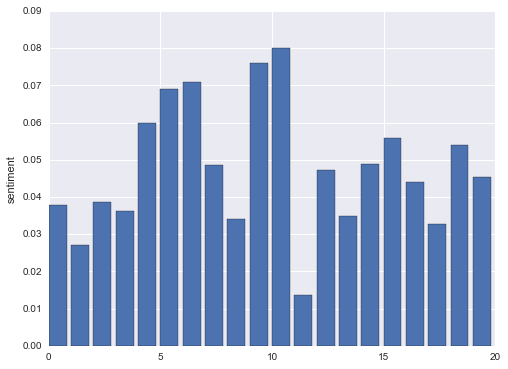

In [63]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [64]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
7796,"""I see that child who lay upon her bosom and w...","[1, 3, 4, 5, 3, 3, 4, 3, 5, 3, 3, 4, 2, 4, 1, ...",98,"[1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, ...",32,0.500000
7797,"I see him winning it so well, that my name is ...","[1, 3, 3, 7, 2, 2, 4, 4, 2, 4, 2, 4, 11, 5, 2,...",69,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...",22,0.450000
7798,"I see the blots I threw upon it, faded away.","[1, 3, 3, 5, 1, 5, 4, 2, 5, 4]",33,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 2]",12,0.000000
7799,"I see him, fore-most of just judges and honour...","[1, 3, 3, 9, 2, 4, 6, 3, 8, 3, 8, 1, 3, 2, 2, ...",222,"[1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, ...",75,0.500000
7800,"""It is a far, far better thing that I do, than...","[2, 2, 1, 3, 3, 6, 5, 4, 1, 2, 4, 1, 4, 4, 4, ...",94,"[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, ...",35,0.233333


In [65]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [66]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:2443]
df_novel['total_char'][2443:4998]
df_novel['total_char'][4998:7801]


KeyboardInterrupt: 

In [67]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
2443
0.0459558581576
2443
4998
0.0517354971462
4998
7801
0.0472929695386


In [68]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.04595586  0.0517355   0.04729297]


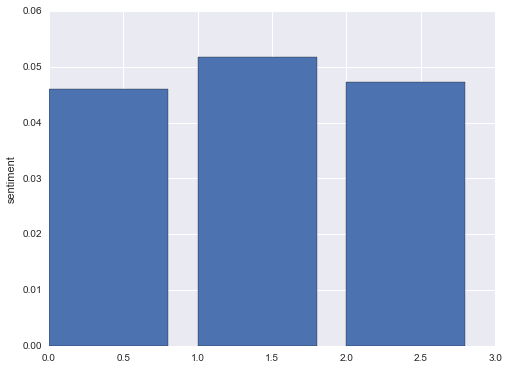

In [69]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers